#### Importing external packages

In [2]:
%load_ext autoreload 

%autoreload 2


import numpy as np
import pandas as pd
import sys
from collections import Counter
from keras import layers
import keras
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Resizing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

#### Importing internal packages

In [9]:
# Add a directory path to sys.path
sys.path.append('/Users/niknmirosh/Code/Yassinoko/dynamic-players-insights/ml_models/')

In [10]:
# from get_images import get_players_images_cropped
# from class_preprocessing import preprocessing_classes
# from image_preprocessing import processing_images
from data_library.data_processing import black_white, crop, delete_face_images, encode, to_cat

#### Uploading data

In [11]:
cropped_faces_directory = "../data_processing/raw_data/video_cropped_faces"

In [28]:
data = get_players_images_cropped()
data

{'image': [array([[[ 78,  71,  65],
          [ 38,  31,  25],
          [ 59,  52,  46],
          ...,
          [  9,   8,  14],
          [  9,   8,  14],
          [  9,   8,  14]],
  
         [[ 60,  53,  47],
          [ 71,  64,  58],
          [ 73,  66,  60],
          ...,
          [  9,   8,  14],
          [  9,   8,  14],
          [  8,   7,  13]],
  
         [[ 61,  54,  48],
          [ 82,  75,  69],
          [106,  99,  93],
          ...,
          [  9,   8,  14],
          [  9,   8,  14],
          [  8,   7,  13]],
  
         ...,
  
         [[165,  99,  77],
          [167, 102,  80],
          [166, 104,  83],
          ...,
          [ 13,  13,  15],
          [ 13,  13,  15],
          [ 12,  11,  17]],
  
         [[165,  99,  77],
          [165, 100,  78],
          [165, 103,  82],
          ...,
          [ 13,  13,  15],
          [ 13,  13,  15],
          [ 12,  11,  17]],
  
         [[169, 103,  81],
          [165, 100,  78],
          [163,

In [1]:
# plt.imshow(data['image'][0])

In [ ]:
# data['name'] = data['name'][:20]
# data['image'] = data['image'][:20]

#### Preprocessing data

In [ ]:
np.mean([s.shape[1] for s in data['image']])

In [97]:
# Yassin approach
y, X = encode(cropped_faces_directory)
y_cat = to_cat(y)

In [44]:
# X, y = processing_images(data)
# X, y = data['image'], data['name']

120


100%|█████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 3419.97it/s]

(120, 64, 64, 3)


In [13]:
X.shape

(320, 64, 64, 3)

In [ ]:
plt.imshow(X[5,:,:,:])

In [45]:
y = preprocessing_classes(y)

In [22]:
y_cat.shape

(640,)

#### Building augmentation pipeline

In [ ]:
# Compute most common shape to set as an input shape
def most_common(lst):
    counter = Counter(lst)
    most_common_item = max(counter, key=counter.get)
    return most_common_item

shapes = [img.shape for img in data['image']]
common = most_common(shapes)

In [98]:
# img_height = common[0]
# img_width = common[1]

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip(),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
  ]
)


for _ in range(3):
    X = np.concatenate((X, data_augmentation(X)))
    y_cat = np.concatenate((y_cat, y_cat))
    
X.shape, y_cat.shape

((2560, 64, 64, 3), (2560, 10))

#### Initializing the model

In [161]:
def initialize_model():
    model = models.Sequential()
    # model.add(layers.RandomFlip())
    # model.add(layers.RandomRotation(0.1))
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25)) 
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25)) 
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(y_cat.shape[-1], activation='softmax', name="outputs"))
    
    opt = keras.optimizers.Adam(learning_rate=0.00065)
    model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

#### Splitting the data

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
# ## Loading VGG16 model
# base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
# base_model.trainable = False ## Not trainable weights

# ## Preprocessing input
# X_train = preprocess_input(X_train) 
# X_train = preprocess_input(X_test)

In [ ]:
# base_model.summary()

In [ ]:
# flatten_layer = layers.Flatten()
# dense_layer_1 = layers.Dense(50, activation='relu')
# dense_layer_2 = layers.Dense(20, activation='relu')
# prediction_layer = layers.Dense(y.shape[-1], activation='softmax')


# model = models.Sequential([
#     base_model,
#     flatten_layer,
#     dense_layer_1,
#     dense_layer_2,
#     prediction_layer
# ])

In [ ]:
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy'],
# )

In [49]:
X_train.shape

(672, 64, 64, 3)

In [ ]:
plt.imshow(X_train[0,:,:,:])

#### Fitting the model

In [165]:
model = initialize_model()

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=16, 
                    verbose=1, callbacks=[es], 
                    validation_data=(X_test, y_test))

Epoch 1/100
112/112 [==============================] - 3s 16ms/step - loss: 40.6019 - accuracy: 0.1133 - val_loss: 19.1719 - val_accuracy: 0.1341
Epoch 2/100
112/112 [==============================] - 2s 15ms/step - loss: 18.9345 - accuracy: 0.1110 - val_loss: 18.4487 - val_accuracy: 0.1068
Epoch 3/100
112/112 [==============================] - 2s 15ms/step - loss: 18.0959 - accuracy: 0.1172 - val_loss: 17.6776 - val_accuracy: 0.1042
Epoch 4/100
112/112 [==============================] - 2s 15ms/step - loss: 17.3193 - accuracy: 0.1228 - val_loss: 16.9284 - val_accuracy: 0.1341
Epoch 5/100
112/112 [==============================] - 2s 15ms/step - loss: 16.5651 - accuracy: 0.1311 - val_loss: 16.2133 - val_accuracy: 0.1146
Epoch 6/100
112/112 [==============================] - 2s 16ms/step - loss: 15.8554 - accuracy: 0.1239 - val_loss: 15.4642 - val_accuracy: 0.1055
Epoch 7/100
112/112 [==============================] - 2s 16ms/step - loss: 15.1506 - accuracy: 0.1278 - val_loss: 14.8051 -

In [166]:
test_accuracy = model.evaluate(X_test, y_test)[1]
test_accuracy

24/24 [==============================] - 0s 7ms/step - loss: 0.8555 - accuracy: 1.0000


1.0

In [117]:
history.history

{'loss': [29.84208869934082,
  18.26679229736328,
  16.784061431884766,
  15.438162803649902,
  14.206485748291016,
  13.060145378112793,
  12.056822776794434,
  11.115561485290527,
  10.286211013793945,
  9.516427993774414,
  8.775053977966309,
  8.135214805603027,
  7.561099052429199,
  7.087630748748779,
  6.577347278594971,
  6.148076057434082,
  5.689448833465576,
  5.487051963806152,
  5.1184892654418945,
  4.774419784545898,
  4.453306674957275,
  4.053389549255371,
  3.83328914642334,
  3.5593836307525635,
  3.340806484222412,
  3.1879360675811768,
  3.035646677017212,
  2.775468587875366,
  2.6534178256988525,
  2.5132930278778076,
  2.4919934272766113,
  2.349806070327759,
  2.2318344116210938,
  2.0787789821624756,
  2.000864267349243,
  2.073983669281006,
  2.0098133087158203,
  1.8217295408248901,
  1.9492295980453491,
  1.8395339250564575,
  1.8320482969284058,
  1.8095524311065674,
  1.8177151679992676,
  1.764678955078125,
  1.568826675415039,
  1.554200530052185,
  1.6

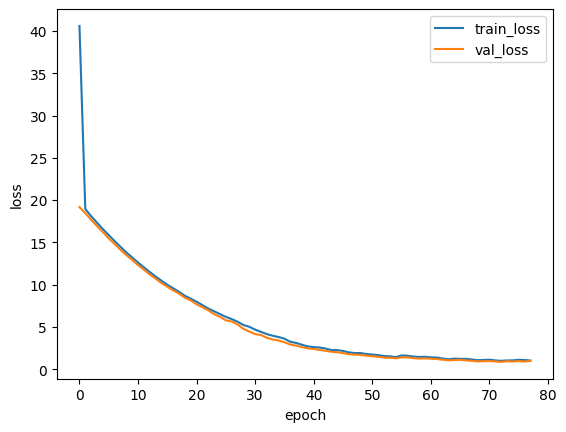

In [167]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [158]:
test_accuracy = model.evaluate(X_test, y_test)[1]
test_accuracy

28/28 [==============================] - 0s 7ms/step - loss: 1.5424 - accuracy: 1.0000


1.0

#### Saving the models

In [168]:
from tensorflow.keras.models import load_model, save_model

# Assuming 'model' is your trained model
# Save the entire model (architecture and weights) to a single file
save_model(model, f'../ml_models/saved_models/model_99_nik.h5')

# To load the saved model later
# loaded_model = load_model('')